In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray
import matplotlib.pyplot as plt
from shapely.geometry import box
from scipy.signal import savgol_filter
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
import rioxarray

from func_processing import ts_telcirkel_per_jaar, bare_soil_calc, bare_soil_format


## Settings


In [3]:
vi_str = 'bsi' # van welke vegetatie-index analyse doen?

output_folder = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/rasters-telcirkels' #folder location of the rasters

path_2022 = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2022_clip.gpkg'
path_2023 = 'Q:/Projects/PRJ_MBAG/4d_bwk/project-telcirkels/landbouwgebruikspercelen_cut_bo_2023_clip.gpkg'


In [ ]:

#---- 
# Reading in all the parcels from Z-/Q-schijf and combining into one 
gdf_2022 = gpd.read_file(path_2022).to_crs(32631)
gdf_2023 = gpd.read_file(path_2023).to_crs(32631)
#----

# Dictionary met de geodataframes per jaar (aanpassen als je meer of minder jaren wilt, moet natuurlijk binnen het tijdsbereik waarvoor er rasters gedownload zijn)
analysis_years_dict = {2022: gdf_2022, 2023: gdf_2023}

# Dictionary met de telperiodes (hard-coded...)
periods = {
'R1_2022': ('2022-04-01', '2022-04-20'),
'R2_2022': ('2022-04-21', '2022-05-10'),
'R3_2022': ('2022-05-11', '2022-06-10'),
'R4_2022': ('2022-06-21', '2022-07-15'),
'R1_2023': ('2023-04-01', '2023-04-20'),
'R2_2023': ('2023-04-21', '2023-05-10'),
'R3_2023': ('2023-05-11', '2023-06-10'),
'R4_2023': ('2023-06-21', '2023-07-15')}

## Bare soil analysis
Eerst de weggeschreven rasters terug inladen op de juiste manier (time index valt onder andere weg blijkbaar). Daarna op de ingeladen data de *bare soil analysis* doen. De analyse op de weggeschreven rasters doen gaat veel sneller dan het rechtstreeks uit te voeren wanneer de data van earth engine komt! De *bare soil analysis* moet per jaar apart gebeuren met de bijbehorende landbouwgebruikspercelen, terwijl de rasters gedownload zijn voor verschillenden jaren tegelijk. In deze analyse moet dus andere polygonen gebruikt worden afhankelijk van het jaar.

<Axes: >

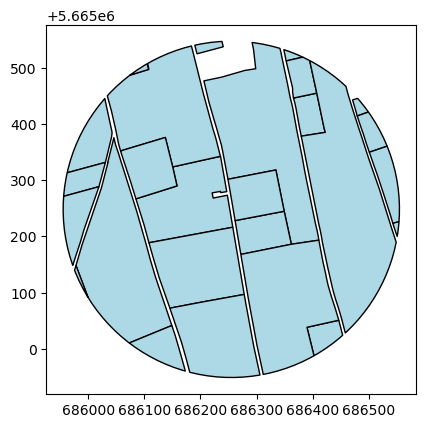

In [14]:
gdf_2022.head(5)


# CRS should be 4326
gdf_2022.loc[(gdf_2022.pointid == 'Km_26663.17')].plot(color='lightblue', edgecolor='black', linewidth=1)

In [41]:
#-- Aggregation of time series over polygons
# Create empty dataframe for storage results (polygon-aggregated time series)
df_ts = pd.DataFrame(columns=['REF_ID', 'pointid', 'time', vi_str])

raster_files = [file for file in os.listdir(output_folder) if vi_str in file]

for file in raster_files:
    print(file)
    
    # Open the raster file
    raster = rioxarray.open_rasterio(os.path.join(output_folder,file))

    # Extract dates from the 'long_name' attribute, convert to datetime & assign to 'band' coordinate
    dates = [raster.attrs['long_name'][i] for i in range(len(raster.band))]
    time_index = pd.to_datetime(dates)
    raster['band'] = time_index


    # Xarray settings
    raster = raster.rename({'band': 'time', 'x' : 'X', 'y': 'Y'}).transpose('time', 'X', 'Y')
    raster = raster.rio.set_spatial_dims('X','Y')
    raster.rio.write_crs("EPSG:32631", inplace=True)

    # Extract pointid
    # pointid moet overeenkomen met de raster waarvoor de data opgehaald wordt, anders probleem met geen overlap tussen raster en polygon
    parts = file.split('_')
    pointid = parts[3] + '_' + parts[4]
        
    # In deze for-loop worden de tijdsreeksen voor het telpunt per jaar apart toegevoegd; afhankelijk van de geodataframes die in de dictionary zitten
    for year, gdf_year in analysis_years_dict.items():
        df_ts = ts_telcirkel_per_jaar(raster=raster, gdf=gdf_year, year=year, pointid=pointid, df_ts=df_ts)

df_ts = df_ts.sort_values(by = ['pointid','REF_ID','time']).reset_index(drop=True)
df_ts = df_ts[['pointid', 'REF_ID', 'time', vi_str]]
df_ts.to_csv(f'../outputs/output_analysis/time_series_{vi_str}.csv')

df_ts

multiband_raster_ndvi_Km_10015_sg.tif
multiband_raster_ndvi_Km_10019_sg.tif
multiband_raster_ndvi_Km_10056.3_sg.tif
multiband_raster_ndvi_Km_10565.2.3_sg.tif
multiband_raster_ndvi_Km_10577.3_sg.tif
multiband_raster_ndvi_Km_10810.1_sg.tif
multiband_raster_ndvi_Lm_11070_sg.tif
multiband_raster_ndvi_Lm_11568.1_sg.tif
multiband_raster_ndvi_Lm_15064.9_sg.tif
multiband_raster_ndvi_Lm_8486.3_sg.tif
multiband_raster_ndvi_Lm_8898.1.8_sg.tif
multiband_raster_ndvi_Lm_9709.1.6_sg.tif
multiband_raster_ndvi_Zn_10111.7_sg.tif
multiband_raster_ndvi_Zn_10583.5_sg.tif
multiband_raster_ndvi_Zn_11411.7_sg.tif


,pointid,REF_ID,time,ndvi
0,Km_10015,403232939,2022-02-01,0.131130
1,Km_10015,403232939,2022-02-11,0.211103
2,Km_10015,403232939,2022-02-21,0.275849
3,Km_10015,403232939,2022-03-03,0.334228
4,Km_10015,403232939,2022-03-13,0.351813
...,...,...,...,...
20415,Zn_11411.7,2320375089,2023-07-16,0.634000
20416,Zn_11411.7,2320375089,2023-07-26,0.598350
20417,Zn_11411.7,2320375089,2023-08-05,0.580685
20418,Zn_11411.7,2320375089,2023-08-15,0.585071


De berekeningen van de waarden tussen BSI en NDVI zijn *exact* hetzelfde...

In [42]:
# Do bare soil calculation on every year seperately

for year, gdf_year in analysis_years_dict.items():
    # Formatting before bare soil calculation
    # This format & the calculation should be changed if it turns out that it is too heavy for processing
    gdf_ts_year = bare_soil_format(df_ts, gdf_year, year, vi_str)
    
    # Bare soil calculation
    result = bare_soil_calc(gdf_ts_year, vi_str, periods)

    result.to_csv(f'../outputs/output_analysis/bare_soil_analysis_{vi_str}_{year}_v3.csv')

result.head(5)
#gdf_ts[['OIDN', 'pointid', 'date', 'ndvi','geometry']].head(3)
#gdf.loc[~gdf.OIDN.isin(gdf_ts.OIDN.unique().tolist())].to_file('../outputs/empty_geometries.gpkg')

,pointid,year,period,% bare soil
0,Km_10015,2023,R1,0.499656
1,Km_10019,2023,R1,29.591673
2,Km_10056.3,2023,R1,9.964779
3,Km_10565.2.3,2023,R1,46.105010
4,Km_10577.3,2023,R1,4.102443


In [44]:
bare_soil_calc(gdf_ts_year, 'ndvi', periods)

Km_10015       pointid      REF_ID       date      ndvi  \
9    Km_10015   403232939 2023-04-07  0.605710   
10   Km_10015   403232939 2023-04-17  0.618154   
33   Km_10015   407498818 2023-04-07  0.571004   
34   Km_10015   407498818 2023-04-17  0.577951   
57   Km_10015   419549652 2023-04-07  0.593263   
58   Km_10015   419549652 2023-04-17  0.607718   
81   Km_10015   427696137 2023-04-07  0.614566   
82   Km_10015   427696137 2023-04-17  0.615417   
105  Km_10015   427696440 2023-04-07       NaN   
106  Km_10015   427696440 2023-04-17       NaN   
129  Km_10015   431934532 2023-04-07  0.631715   
130  Km_10015   431934532 2023-04-17  0.649499   
153  Km_10015   439997050 2023-04-07  0.622844   
154  Km_10015   439997050 2023-04-17  0.639549   
177  Km_10015   757484619 2023-04-07  0.250402   
178  Km_10015   757484619 2023-04-17  0.227690   
201  Km_10015   814618023 2023-04-07  0.632944   
202  Km_10015   814618023 2023-04-17  0.637533   
225  Km_10015   814702188 2023-04-07  0.5